<center> <h1 style="background-color:black; color:white" >Spaceship Titanic</h1>

<center><h1><strong></strong></h1>
<img
src="https://storage.googleapis.com/kaggle-media/competitions/Spaceship%20Titanic/joel-filipe-QwoNAhbmLLo-unsplash.jpg" width="540" height="428">
</center>

# Kütüphaneler

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import time
import os
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightgbm as lgb
import datetime as dt
import warnings
from pandas_profiling import ProfileReport
from catboost import CatBoostRegressor, CatBoostClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

%matplotlib inline
color = '#07663c'
cmap1 = 'Green'
cmap2 =  'Set3'
palette1 = 'Green'
palette2 = 'Set3'


/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
train_df = pd.read_csv('../input/spaceship-titanic/train.csv', index_col='PassengerId')
test_df = pd.read_csv('../input/spaceship-titanic/test.csv', index_col='PassengerId')

# df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

In [3]:
train_df['Transported'].replace(False, 0, inplace=True)
train_df['Transported'].replace(True, 1, inplace=True)

# Veri Keşfi

In [4]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


check_df(train_df)

##################### Shape #####################
(8693, 13)
##################### Types #####################
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported       int64
dtype: object
##################### Head #####################
            HomePlanet CryoSleep  Cabin  Destination   Age    VIP  RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  Transported
PassengerId                                                                                                                                            
0001_01         Europa     False  B/0/P  TRAPPIST-1e 39.00  False         0.00       0.00          0.00    0.00    0.00    Maham Ofracculy            0
0002_01          Earth     False  F/0/S  TRAPPIST-1e 24.00

In [5]:
profile = ProfileReport(train_df, title="Genel Rapor")
profile.to_file("genel_rapor.html")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Veri Keşfi Fonksiyonları

In [6]:
def grab_col_names(dataframe, cat_th=10, car_th=20): 
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(train_df)

Observations: 8693
Variables: 13
cat_cols: 5
num_cols: 6
cat_but_car: 2
num_but_cat: 1


############## Unique Observations of Categorical Data ###############
The unique number of HomePlanet: 3
############## Frequency of Categorical Data ########################
        HomePlanet  Ratio
Earth         4602   0.53
Europa        2131   0.25
Mars          1759   0.20


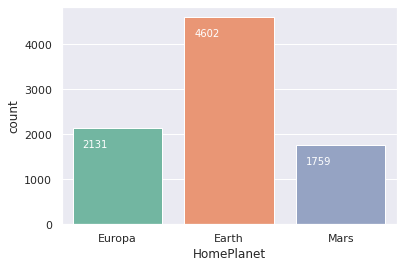

############## Unique Observations of Categorical Data ###############
The unique number of CryoSleep: 2
############## Frequency of Categorical Data ########################
       CryoSleep  Ratio
False       5439   0.63
True        3037   0.35


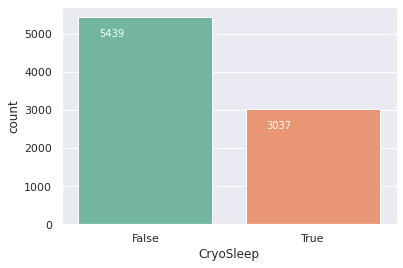

############## Unique Observations of Categorical Data ###############
The unique number of Destination: 3
############## Frequency of Categorical Data ########################
               Destination  Ratio
TRAPPIST-1e           5915   0.68
55 Cancri e           1800   0.21
PSO J318.5-22          796   0.09


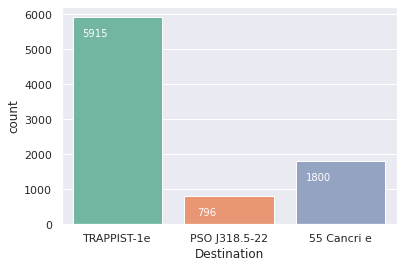

############## Unique Observations of Categorical Data ###############
The unique number of VIP: 2
############## Frequency of Categorical Data ########################
        VIP  Ratio
False  8291   0.95
True    199   0.02


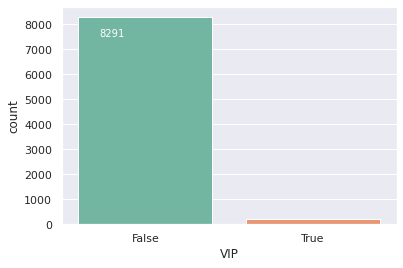

############## Unique Observations of Categorical Data ###############
The unique number of Transported: 2
############## Frequency of Categorical Data ########################
   Transported  Ratio
1         4378   0.50
0         4315   0.50


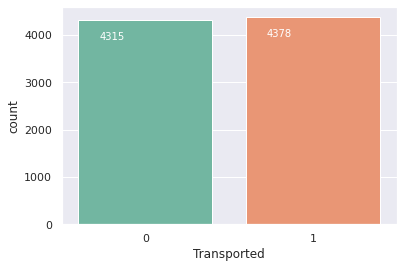

In [7]:
def cat_summary(dataframe, plot=False):
    for col_name in cat_cols:
        print("############## Unique Observations of Categorical Data ###############")
        print("The unique number of "+ col_name+": "+ str(dataframe[col_name].nunique()))

        print("############## Frequency of Categorical Data ########################")
        print(pd.DataFrame({col_name : dataframe[col_name].value_counts(),
                            "Ratio": dataframe[col_name].value_counts()/len(dataframe)}))
        if plot == True:
            rgb_values = sns.color_palette("Set2", 6)
            sns.set_theme(style="darkgrid")
            ax = sns.countplot(x=dataframe[col_name], data=dataframe, palette=rgb_values)
            for p in ax.patches:
                ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=10)
            plt.show()
            
            
cat_summary(train_df, plot=True)

########## Summary Statistics of Age ############
count   8514.00
mean      28.83
std       14.49
min        0.00
25%       19.00
50%       27.00
75%       38.00
100%      79.00
max       79.00
Name: Age, dtype: float64


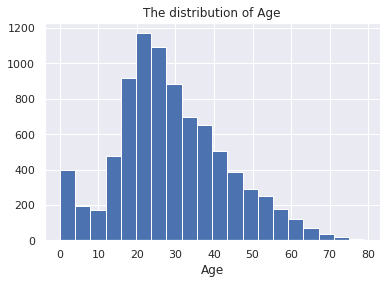

########## Summary Statistics of RoomService ############
count    8512.00
mean      224.69
std       666.72
min         0.00
25%         0.00
50%         0.00
75%        47.00
100%    14327.00
max     14327.00
Name: RoomService, dtype: float64


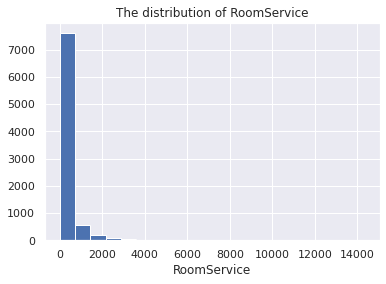

########## Summary Statistics of FoodCourt ############
count    8510.00
mean      458.08
std      1611.49
min         0.00
25%         0.00
50%         0.00
75%        76.00
100%    29813.00
max     29813.00
Name: FoodCourt, dtype: float64


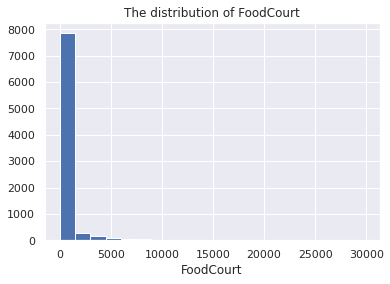

########## Summary Statistics of ShoppingMall ############
count    8485.00
mean      173.73
std       604.70
min         0.00
25%         0.00
50%         0.00
75%        27.00
100%    23492.00
max     23492.00
Name: ShoppingMall, dtype: float64


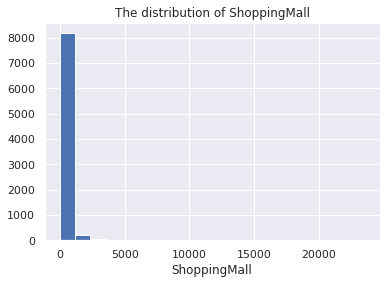

########## Summary Statistics of Spa ############
count    8510.00
mean      311.14
std      1136.71
min         0.00
25%         0.00
50%         0.00
75%        59.00
100%    22408.00
max     22408.00
Name: Spa, dtype: float64


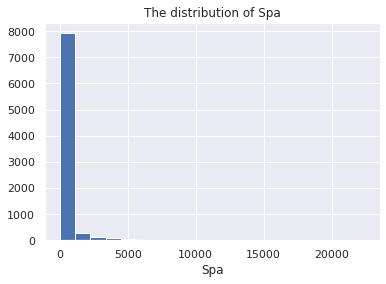

########## Summary Statistics of VRDeck ############
count    8505.00
mean      304.85
std      1145.72
min         0.00
25%         0.00
50%         0.00
75%        46.00
100%    24133.00
max     24133.00
Name: VRDeck, dtype: float64


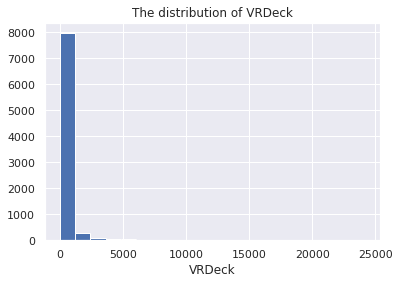

In [8]:
def num_summary(dataframe, plot=False):
    quantiles = [0.25, 0.50, 0.75, 1]
    for col in num_cols:
      print("########## Summary Statistics of " +  col + " ############")
      print(dataframe[col].describe(quantiles).T)
      if plot:
          dataframe[col].hist(bins=20)
          plt.xlabel(col)
          plt.title("The distribution of "+ col)
          plt.show()
        
        
num_summary(train_df, plot=True)

In [9]:
def target_summary_with_cat(dataframe, target, categorical_col, target_type="num"):
    if target_type == "num":
        print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(
            categorical_col)[target].mean()}), end="\n\n\n")
    else:
        print(pd.DataFrame({categorical_col + "_COUNT": dataframe.groupby(categorical_col)[target].count()}),
              end="\n\n\n")   


for col in cat_cols:
    target_summary_with_cat(train_df, "Transported", col)

            TARGET_MEAN
HomePlanet             
Earth              0.42
Europa             0.66
Mars               0.52


           TARGET_MEAN
CryoSleep             
False             0.33
True              0.82


               TARGET_MEAN
Destination               
55 Cancri e           0.61
PSO J318.5-22         0.50
TRAPPIST-1e           0.47


       TARGET_MEAN
VIP               
False         0.51
True          0.38


             TARGET_MEAN
Transported             
0                   0.00
1                   1.00




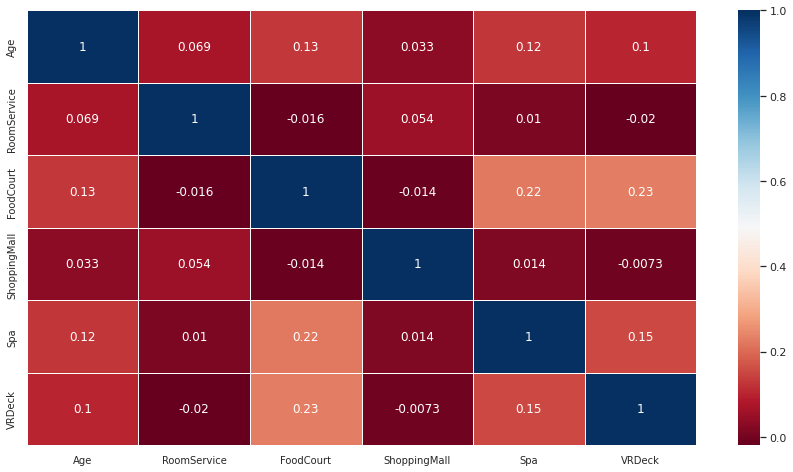

In [10]:
def correlation_matrix(dataframe, cols):
    fig = plt.gcf()
    fig.set_size_inches(15, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(dataframe[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w',
                      cmap='RdBu')
    plt.show(block=True)
    
    
correlation_matrix(train_df, num_cols)    

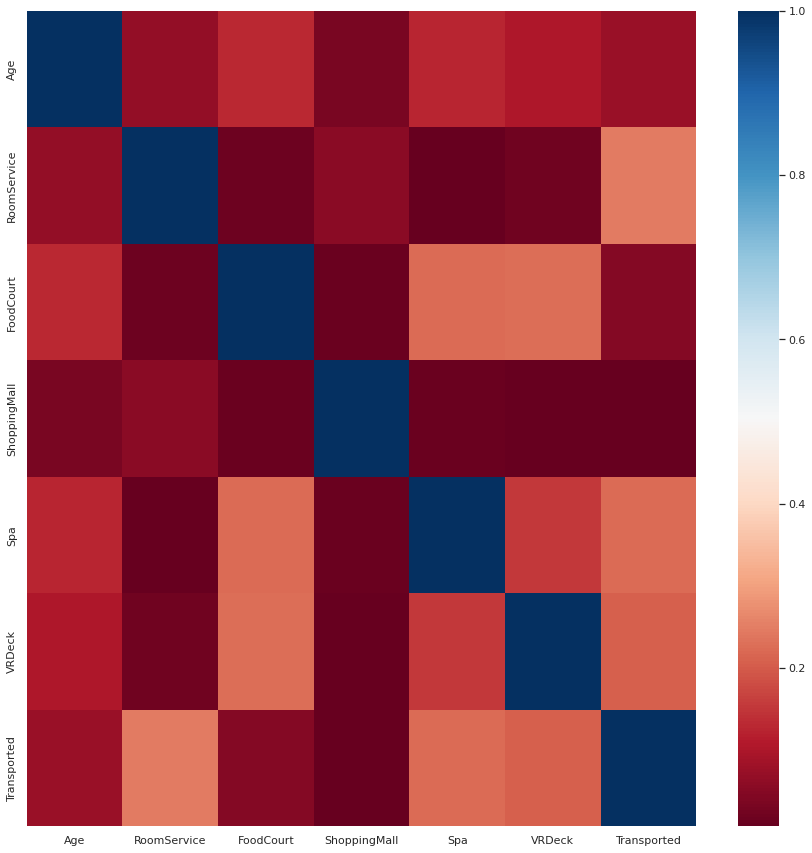

In [11]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.80):
    corr = dataframe.corr()
    corr_matrix = corr.abs()
    upper_triangle_matrix = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns
                 if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={"figure.figsize": (15, 15)})
        sns.heatmap(corr_matrix, cmap="RdBu")
        plt.show()
    return drop_list


drop_list = high_correlated_cols(train_df, plot=True)

In [12]:
drop_list

[]

# Kayıp Veriler

In [13]:
def missing_values_table(dataframe, na_name=True):
    na_columns = [
        col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum()
    miss_dtypes = dataframe[na_columns].dtypes
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    
    missing_df = pd.concat([n_miss, ratio, miss_dtypes], axis=1, keys=["Missing_Values (#)", "Ratio (%)", "Type"])
    print(missing_df)
    print("************* Number of Missing Values *************")
    print(dataframe.isnull().sum().sum())
    if na_name:
        return na_columns
    

na_columns = missing_values_table(train_df, na_name=True)

              Missing_Values (#)  Ratio (%)     Type
HomePlanet                   201       2.31   object
CryoSleep                    217       2.50   object
Cabin                        199       2.29   object
Destination                  182       2.09   object
Age                          179       2.06  float64
VIP                          203       2.34   object
RoomService                  181       2.08  float64
FoodCourt                    183       2.11  float64
ShoppingMall                 208       2.39  float64
Spa                          183       2.11  float64
VRDeck                       188       2.16  float64
Name                         200       2.30   object
************* Number of Missing Values *************
2324


In [14]:
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + "_NA_FLAG"] = np.where(temp_df[col].isnull(), 1, 0)
        na_flag_df = temp_df.loc[:, temp_df.columns.str.contains("_NA_")]
    for col in na_flag_df:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby([col])[target].mean(),
                            "COUNT": temp_df.groupby([col])[target].count()}), end="\n\n\n")
        

        
missing_vs_target(train_df, "Transported", na_columns)
              

                    TARGET_MEAN  COUNT
HomePlanet_NA_FLAG                    
0                          0.50   8492
1                          0.51    201


                   TARGET_MEAN  COUNT
CryoSleep_NA_FLAG                    
0                         0.50   8476
1                         0.49    217


               TARGET_MEAN  COUNT
Cabin_NA_FLAG                    
0                     0.50   8494
1                     0.50    199


                     TARGET_MEAN  COUNT
Destination_NA_FLAG                    
0                           0.50   8511
1                           0.51    182


             TARGET_MEAN  COUNT
Age_NA_FLAG                    
0                   0.50   8514
1                   0.50    179


             TARGET_MEAN  COUNT
VIP_NA_FLAG                    
0                   0.50   8490
1                   0.51    203


                     TARGET_MEAN  COUNT
RoomService_NA_FLAG                    
0                           0.50   8512
1       

# Veri Hazırlama

In [15]:
train_df.drop('Name', axis=1, inplace=True)
test_df.drop('Name', axis=1, inplace=True)

train_df[['Deck','Num', 'Side']] = train_df['Cabin'].str.split('/', expand=True)
test_df[['Deck','Num', 'Side']] = test_df['Cabin'].str.split('/', expand=True)

train_df.drop('Cabin', axis=1, inplace=True)
test_df.drop('Cabin', axis=1, inplace=True)

toplam_harcama = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

train_df['SumSpends'] = train_df[toplam_harcama].sum(axis=1)
test_df['SumSpends'] = test_df[toplam_harcama].sum(axis=1)

# Veri Dönüşümü

In [16]:
ordinal_encode = OrdinalEncoder()

df_for_encode = pd.concat([train_df, test_df])

cat_cols, num_cols, cat_but_car = grab_col_names(df_for_encode)

na_columns = missing_values_table(df_for_encode)

df_for_encode[cat_cols] = df_for_encode[cat_cols].astype('category')

df_for_encode[cat_cols] = ordinal_encode.fit_transform(df_for_encode[cat_cols])

del train_df, test_df

train_df = df_for_encode.iloc[:8693, :]
test_df = df_for_encode.iloc[8693: , :]

del df_for_encode

test_df.drop('Transported', inplace=True, axis=1)


Observations: 12970
Variables: 15
cat_cols: 7
num_cols: 7
cat_but_car: 1
num_but_cat: 1
              Missing_Values (#)  Ratio (%)     Type
HomePlanet                   288       2.22   object
CryoSleep                    310       2.39   object
Destination                  274       2.11   object
Age                          270       2.08  float64
VIP                          296       2.28   object
RoomService                  263       2.03  float64
FoodCourt                    289       2.23  float64
ShoppingMall                 306       2.36  float64
Spa                          284       2.19  float64
VRDeck                       268       2.07  float64
Transported                 4277      32.98  float64
Deck                         299       2.31   object
Num                          299       2.31   object
Side                         299       2.31   object
************* Number of Missing Values *************
8022


# Kayıp Veri Tamamlama

In [17]:
na_columns_tr = missing_values_table(train_df, na_name=True)

col_transformer = ColumnTransformer([("impute", SimpleImputer(strategy='mean'), na_columns_tr)])
    
train_df[na_columns_tr] = col_transformer.fit_transform(train_df[na_columns_tr])

###########################

# knn_transformer = KNNImputer(n_neighbors=5)
# df_filled = imputer.fit_transform(df_for_encode[na_columns])
# df_for_encode[na_columns] = pd.DataFrame(df_filled, columns=df_for_encode[na_columns].columns)

              Missing_Values (#)  Ratio (%)     Type
HomePlanet                   201       2.31  float64
CryoSleep                    217       2.50  float64
Destination                  182       2.09  float64
Age                          179       2.06  float64
VIP                          203       2.34  float64
RoomService                  181       2.08  float64
FoodCourt                    183       2.11  float64
ShoppingMall                 208       2.39  float64
Spa                          183       2.11  float64
VRDeck                       188       2.16  float64
Deck                         199       2.29  float64
Num                          199       2.29   object
Side                         199       2.29  float64
************* Number of Missing Values *************
2522


In [18]:
na_columns_test = missing_values_table(test_df, na_name=True)

col_transformer = ColumnTransformer([("impute", SimpleImputer(strategy='mean'), na_columns_test)])
    
test_df[na_columns_test] = col_transformer.fit_transform(test_df[na_columns_test])

###########################

# knn_transformer = KNNImputer(n_neighbors=5)
# df_filled = imputer.fit_transform(df_for_encode[na_columns])
# df_for_encode[na_columns] = pd.DataFrame(df_filled, columns=df_for_encode[na_columns].columns)

              Missing_Values (#)  Ratio (%)     Type
HomePlanet                    87       2.03  float64
CryoSleep                     93       2.17  float64
Destination                   92       2.15  float64
Age                           91       2.13  float64
VIP                           93       2.17  float64
RoomService                   82       1.92  float64
FoodCourt                    106       2.48  float64
ShoppingMall                  98       2.29  float64
Spa                          101       2.36  float64
VRDeck                        80       1.87  float64
Deck                         100       2.34  float64
Num                          100       2.34   object
Side                         100       2.34  float64
************* Number of Missing Values *************
1223


In [19]:
cat_cols, num_cols, cat_but_car = grab_col_names(train_df)

Observations: 8693
Variables: 15
cat_cols: 7
num_cols: 8
cat_but_car: 0
num_but_cat: 7


# Aykırı Değerler

In [20]:
def outlier_thresholds(dataframe, col_name, q1 = 0.01, q3 = 0.99):
    Q1 = dataframe[col_name].quantile(q1)
    Q3 = dataframe[col_name].quantile(q3)
    IQR = Q3 - Q1
    low_limit = Q1 - 1.5 * IQR
    up_limit = Q3 + 1.5 * IQR
    
    return low_limit, up_limit


def check_outlier(dataframe, col_name, q1=0.01, q3=0.99):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
    
for col in num_cols:
    print(col, ":", check_outlier(train_df, col))

print("****************************************")

for col in num_cols:
    print(col, ":", check_outlier(train_df, col, q1=0.25, q3 = 0.75))

Age : False
RoomService : True
FoodCourt : True
ShoppingMall : True
Spa : True
VRDeck : True
Num : False
SumSpends : False
****************************************
Age : True
RoomService : True
FoodCourt : True
ShoppingMall : True
Spa : True
VRDeck : True
Num : False
SumSpends : True


In [21]:
def grab_outliers(dataframe, col_name, index=False, plot=False, q1=0.25, q3=0.75):
    if plot:
        sns.boxplot(x=dataframe[col_name])
        plt.show()
    low, up = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low)
                         | (dataframe[col_name] > up))].head(5))
    else:
        print(dataframe[((dataframe[col_name] < low)
                         | (dataframe[col_name] > up))])
    if index:
        outlier_index = dataframe[(
                (dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index
    
    
for col in num_cols:
    grab_outliers(train_df, col, index=True, plot=False)

             HomePlanet  CryoSleep  Destination   Age  VIP  RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  Transported  Deck    Num  Side  SumSpends
PassengerId                                                                                                                                                
0113_01            0.00       0.00         2.00 64.00 0.00         0.00       0.00        804.00    0.00    0.00         1.00  5.00  23.00  0.00     804.00
0126_01            2.00       1.00         2.00 67.00 0.00         0.00       0.00          0.00    0.00    0.00         1.00  5.00  27.00  1.00       0.00
0270_01            0.00       0.00         2.00 63.00 0.00         0.00      25.00        128.00    0.00 1240.00         0.00  5.00  59.00  0.00    1393.00
0310_01            1.00       0.00         2.00 67.00 0.00       224.69     230.00          0.00 4476.00  241.00         0.00  4.31 600.37  0.50    4947.00
0377_01            1.00       0.00         0.00 63.00 0.00      

In [22]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
    
for col in num_cols:
    replace_with_thresholds(train_df, col)

In [23]:
for col in num_cols:
    print(col, ":", check_outlier(train_df, col))

print("****************************************")

for col in num_cols:
    print(col, ":", check_outlier(train_df, col, q1=0.25, q3 = 0.75))

Age : False
RoomService : False
FoodCourt : False
ShoppingMall : False
Spa : False
VRDeck : False
Num : False
SumSpends : False
****************************************
Age : True
RoomService : True
FoodCourt : True
ShoppingMall : True
Spa : True
VRDeck : True
Num : False
SumSpends : True


In [24]:
for col in num_cols:
    replace_with_thresholds(test_df, col)

In [25]:
for col in num_cols:
    print(col, ":", check_outlier(test_df, col))

Age : False
RoomService : False
FoodCourt : False
ShoppingMall : False
Spa : False
VRDeck : False
Num : False
SumSpends : False


# Makine Öğrenmesi Modeli Kurma

In [26]:
train_df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,SumSpends
PassengerId,,,,,,,,,,,,,,,
0001_01,1.00,0.00,2.00,39.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
0002_01,0.00,0.00,2.00,24.00,0.00,109.00,9.00,25.00,549.00,44.00,1.00,5.00,0.00,1.00,736.00
0003_01,1.00,0.00,2.00,58.00,1.00,43.00,3576.00,0.00,6715.00,49.00,0.00,0.00,0.00,1.00,10383.00
0003_02,1.00,0.00,2.00,33.00,0.00,0.00,1283.00,371.00,3329.00,193.00,0.00,0.00,0.00,1.00,5176.00
0004_01,0.00,0.00,2.00,16.00,0.00,303.00,70.00,151.00,565.00,2.00,1.00,5.00,1.00,1.00,1091.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,1.00,0.00,0.00,41.00,1.00,0.00,6819.00,0.00,1643.00,74.00,0.00,0.00,98.00,0.00,8536.00
9278_01,0.00,1.00,1.00,18.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.00,1499.00,1.00,0.00
9279_01,0.00,0.00,2.00,26.00,0.00,0.00,0.00,1872.00,1.00,0.00,1.00,6.00,1500.00,1.00,1873.00


In [27]:
X = train_df.drop(["Transported"], axis=1)
y = train_df["Transported"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

def base_models(X, y, scoring="accuracy"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy")

Base Models....
accuracy: 0.7728 (LR) 
accuracy: 0.7382 (KNN) 
accuracy: 0.7115 (CART) 
accuracy: 0.7825 (RF) 
accuracy: 0.7603 (Adaboost) 
accuracy: 0.7789 (GBM) 
accuracy: 0.7524 (XGBoost) 
accuracy: 0.7622 (LightGBM) 
accuracy: 0.7681 (CatBoost) 


In [28]:
knn_params = {"n_neighbors": range(2, 50)}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

xgb_parameters = {'gamma' : [0,1],
                'learning_rate': [0.1,0.3],
                'max_depth': [3,6],
                'n_estimators': [50,100],
                'subsample': [0.5, 0.8, 1]}

lgbm_parameters = {'max_depth': [5,10,15],
                    'learning_rate': [0.05,0.1], 
                    'n_estimators': [50,100,200],  
                    'subsample': [0.5,0.8,1]}

gbm_parameters = {"learning_rate" : [0.05,0.1],
                  "n_estimators": [50,100],
                  "min_samples_split": [2,5],
                  "min_samples_leaf":[1,5],
                  "max_depth": [1,3]}

classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               ('LightGBM', LGBMClassifier(), lgbm_parameters),
               ('GBM', GradientBoostingClassifier(), gbm_parameters),
               ('XGBoost', XGBClassifier(), xgb_parameters)
              ]


def hyperparameter_optimization(X, y, cv=10, scoring="accuracy"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

best_models = hyperparameter_optimization(X, y, scoring="accuracy")

Hyperparameter Optimization....
########## KNN ##########
accuracy (Before): 0.7468
accuracy (After): 0.7802
KNN best params: {'n_neighbors': 47}

########## CART ##########
accuracy (Before): 0.7194
accuracy (After): 0.766
CART best params: {'max_depth': 6, 'min_samples_split': 8}

########## LightGBM ##########
accuracy (Before): 0.7865
accuracy (After): 0.7951
LightGBM best params: {'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 100, 'subsample': 0.5}

########## GBM ##########
accuracy (Before): 0.7937
accuracy (After): 0.7963
GBM best params: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

########## XGBoost ##########
accuracy (Before): 0.7741
accuracy (After): 0.7954
XGBoost best params: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}



In [29]:
def voting_classifier(best_models, X, y):
    print("Voting Classifier...")

    voting_clf = VotingClassifier(estimators=[('KNN', best_models["KNN"]),
                                              ('XGBoost', best_models["XGBoost"]),
                                              ('CART', best_models["CART"]),
                                              ('GBM', best_models["GBM"]),
                                              ('LightGBM', best_models["LightGBM"])],
                                  voting='soft').fit(X, y)

    cv_results = cross_validate(voting_clf, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf

voting_clf = voting_classifier(best_models, X, y)

Voting Classifier...
Accuracy: 0.7859289975265532
F1Score: 0.7906209108387189
ROC_AUC: 0.883871519573254


# Tahmin Gerçekleştirme

In [30]:
prediction = voting_clf.predict(test_df)
prediction

array([1., 0., 1., ..., 1., 1., 1.])

In [31]:
submission = pd.DataFrame()
submission.index = test_df.index
submission['Transported'] = prediction
submission['Transported'].replace(0, False, inplace=True)
submission['Transported'].replace(1, True, inplace=True)
submission.to_csv('submission.csv')